# Paragone tra le metriche dei giornali di matematica

In questo script si cerca di fare un paragone delle diverse metriche delle riviste di matematica.

In [16]:
import pandas # Per l'elaborazione dei file csv
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind # Per i test statistici

## Elenco delle riviste ammissibili

Per poter effettuare la valutazione, ci restringiamo all'elenco delle riviste ammissibili secondo ANVUR. Questa lista è ottenuta dagli ultimi dati ANVUR disponibili e relativi alla VQR 2015-2019 al sito: https://www.anvur.it/attivita/vqr/vqr-2015-2019/gev/area-1-scienze-matematiche-e-informatiche/ 

In [30]:
matjournal = {}
for i in [1,2,3,5,6,7,8,9]:
    matjournal[i] = pandas.read_csv('ListaMCQ-SCOPUS/MAT0'+str(i)+'SCOPUS.csv',sep=";")

## Leggiamo i diversi ranking

Per prima cosa carichiamo in memoria i diversi _ranking_ delle riviste. Utilizzeremo per questa analisi
1. Scimago Journal Rank
2. Scopus CiteScore
3. Math Citation Quotient (come riportato dalle tabelle ANVUR/Scopus caricate al punto precedente)
4. SNIP: Source-normalized Impact per Paper, calcolato dal Leiden University Centre for Science and Technology Studies (CWTS) basato sui dati bibliografici di Scopus (Elsevier).

In [31]:
scimago = pandas.read_csv('scimagojr2019.csv',sep=";",low_memory=False) # Dataset SCIMAGO
scopus = pandas.read_csv('scopusextlistMarch2023.csv',sep=";") # Dataset SCOPUS
cwts = pandas.read_excel('CWTS Journal Indicators April 2023.xlsx') # Dataset CWTS

# Costruzione tabella di paragone

Per guardare al comportamento delle diverse misure costruiamo una tabella che contiene:

|Nome della rivista|ISSN|Settore di Appartenenza|SJR|CiteScore|MCQ|SNIP|

Questa tabella avrà righe ripetute perché alcune riviste figureranno per più settori disciplinari. 

In [33]:
df = pandas.DataFrame(columns=['Rivista', 'ISSN', 'SETTORE','SJR','CiteScore','MCQ'])
index = 0
for i in [1,2,3,5,6,7,8,9]:
    for j in range(len(matjournal[i])):
        row = matjournal[i].iloc[[j]]
        titolo = row['Source Title'].iloc[0]
        issn = row['p_issn'].iloc[0]
        settore = 'MAT0'+str(i)
        # Scimago Journal Rank
        if len(scimago.loc[scimago['Title'] == titolo,'SJR']) == 0:
            e_issn = row['e_issn'].iloc[0]
            p_issn = row['p_issn'].iloc[0] 
            if pandas.isna(e_issn):
                chekissn = p_issn;
            else:
                chekissn = e_issn+', '+p_issn
            if len(scimago.loc[scimago['Issn'] == chekissn,'SJR']) == 0:
                sjr = 0
            else:
                if pandas.isna(scimago.loc[scimago['Issn'] == chekissn,'SJR'].values[0]):
                    sjr = 0
                else:
                    sjr = float(scimago.loc[scimago['Issn'] == chekissn,'SJR'].values[0].replace(',', '.'))
        else:
            if pandas.isna(scimago.loc[scimago['Title'] == titolo,'SJR'].values[0]):
                sjr = 0
            else:
                sjr = float(scimago.loc[scimago['Title'] == titolo,'SJR'].values[0].replace(',', '.'))
        if i < 9:
            mcq = float(row['MCQ'].iloc[0].replace(',', '.'))
        else:
            mcq = 0
        # Scopus CiteScore
        if len(scopus.loc[scopus['Source Title (Medline-sourced journals are indicated in Green)'] == titolo,'2021\nCiteScore']) == 0:
            citescore = float(scopus.loc[scopus['Print-ISSN'] == issn,'2021\nCiteScore'].values[0])
        else:
            citescore = float(scopus.loc[scopus['Source Title (Medline-sourced journals are indicated in Green)'] == titolo,'2021\nCiteScore'].values[0])
        # SNIP-CWTS
        if len(cwts.loc[cwts['Source title'] == titolo,'SNIP']) == 0:
            p_issn = row['p_issn'].iloc[0] 
            e_issn = row['e_issn'].iloc[0]
            if len(cwts.loc[cwts['Print ISSN'] == p_issn,'SNIP']) == 0:
                if len(cwts.loc[cwts['Electronic ISSN'] == e_issn,'SNIP']) == 0:
                    snip = 0
                    #DEBUG: print('I cannot find journal (SNIP): '+titolo)
                else:
                    snip = float(cwts.loc[cwts['Electronic ISSN'] == e_issn,'SNIP'].values[-1])                        
            else:
                snip = float(cwts.loc[cwts['Print ISSN'] == p_issn,'SNIP'].values[-1])
        else:
            snip = float(cwts.loc[cwts['Source title'] == titolo,'SNIP'].values[-1])
        # Decomment for debug:
        # print(titolo+' '+issn+' '+' '+str(sjr)+' '+' 0 '+str(mcq) + ' SNIP ' + str(snip))
        newline = pandas.DataFrame({"Rivista": titolo, 
                                   "ISSN": issn,
                                   "SETTORE": settore,
                                   "SJR": sjr,
                                   "CiteScore": citescore,
                                   "MCQ": mcq,
                                   "SNIP": snip},index=[index]);
        df = pandas.concat([df,newline])
        index = index + 1

# Correlazione indici per settore disciplinare
Indaghiamo la correlazione dei diversi indici delle riviste per settore scientifico disciplinare. Per prima cosa visualizziamo degli _scatterplot_ delle varie misure. Idealmente **indici corellati** avranno valori che si addensano sulla diagonale principale della figura. Controlliamo gli indici a due a due.

### MCQ vs SJR

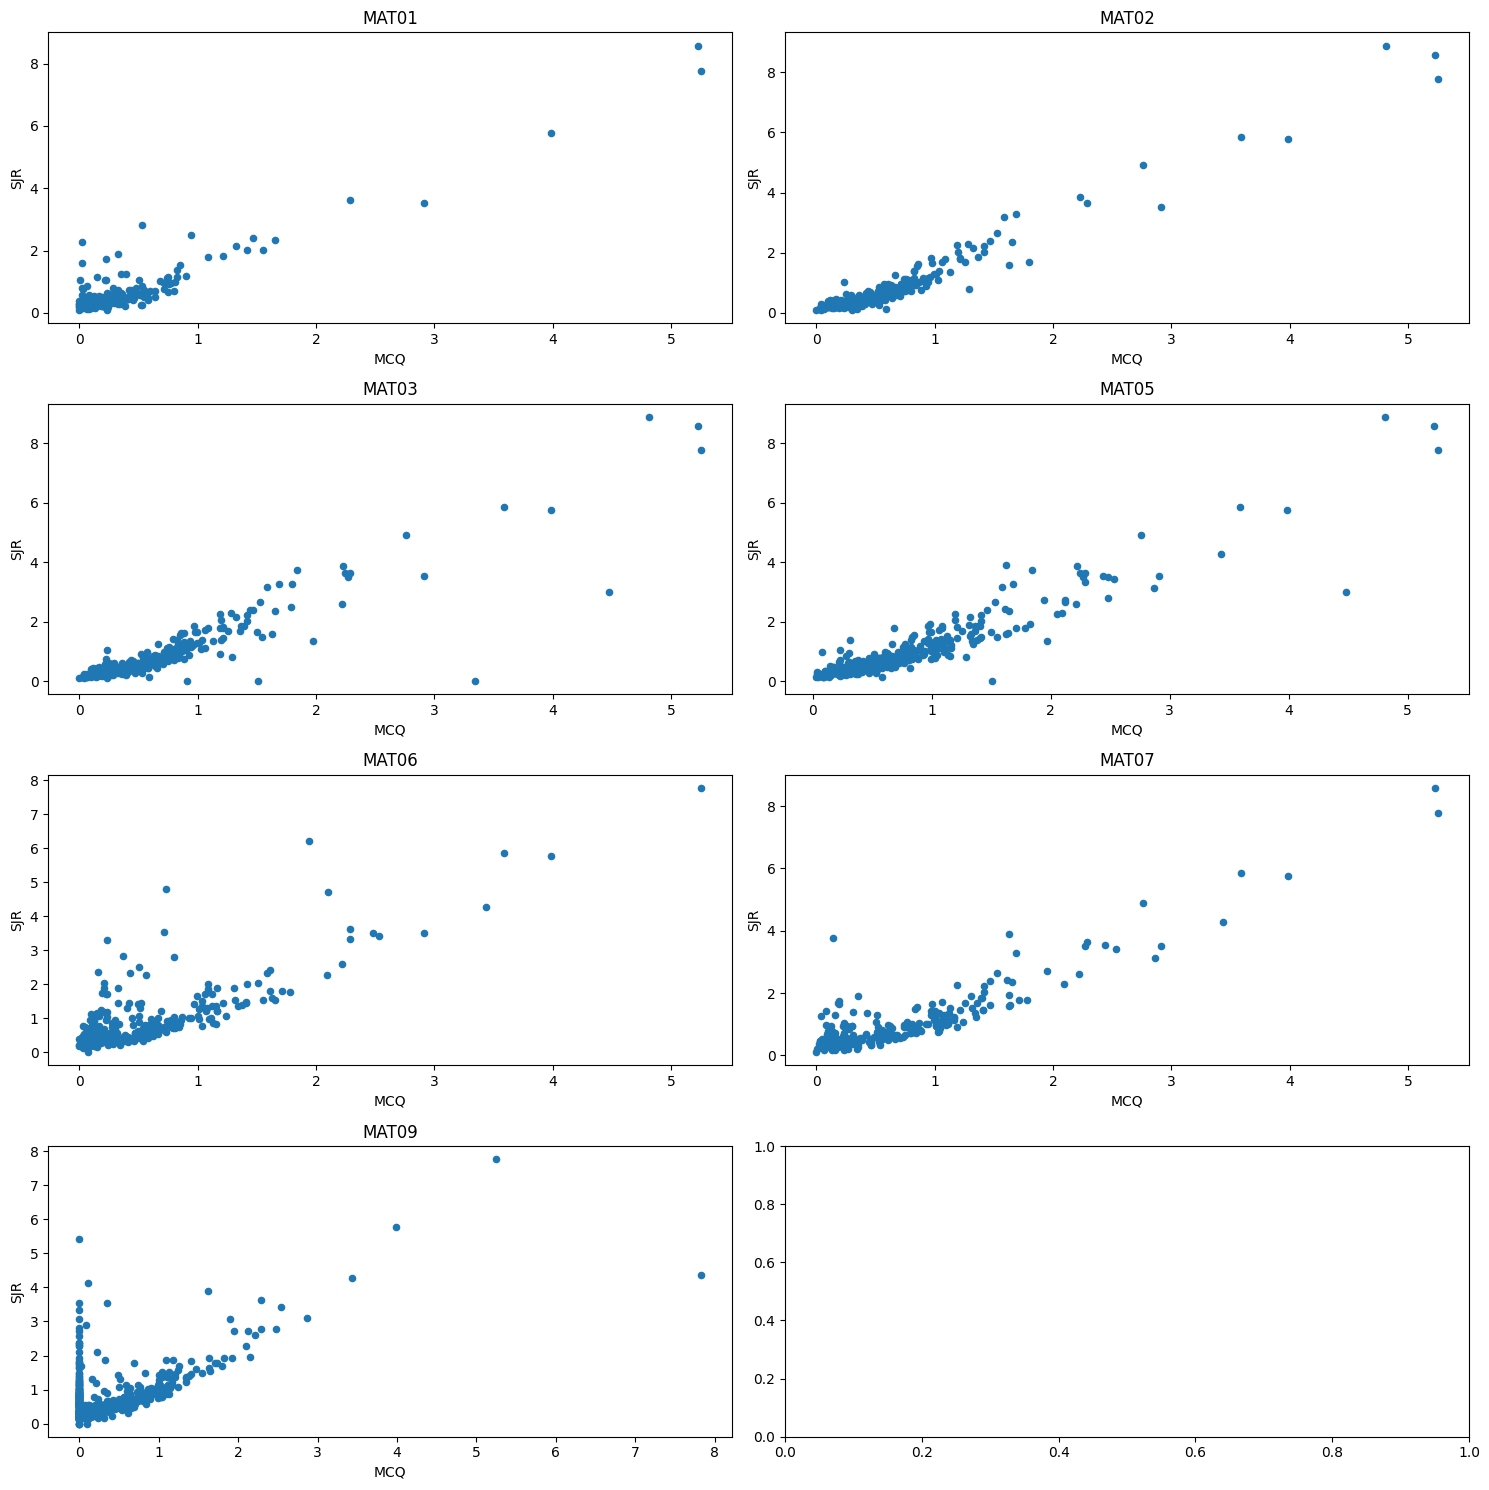

In [34]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
df.loc[df['SETTORE']=='MAT01'].plot.scatter(x="MCQ",y="SJR",ax=axes[0,0],title="MAT01")
df.loc[df['SETTORE']=='MAT02'].plot.scatter(x="MCQ",y="SJR",ax=axes[0,1],title="MAT02")
df.loc[df['SETTORE']=='MAT03'].plot.scatter(x="MCQ",y="SJR",ax=axes[1,0],title="MAT03")
df.loc[df['SETTORE']=='MAT05'].plot.scatter(x="MCQ",y="SJR",ax=axes[1,1],title="MAT05")
df.loc[df['SETTORE']=='MAT06'].plot.scatter(x="MCQ",y="SJR",ax=axes[2,0],title="MAT06")
df.loc[df['SETTORE']=='MAT07'].plot.scatter(x="MCQ",y="SJR",ax=axes[2,1],title="MAT07")
df.loc[df['SETTORE']=='MAT08'].plot.scatter(x="MCQ",y="SJR",ax=axes[3,0],title="MAT08")
df.loc[df['SETTORE']=='MAT09'].plot.scatter(x="MCQ",y="SJR",ax=axes[3,0],title="MAT09")
plt.tight_layout()


Visivamente si osserva che i due _score_ potrebbero avere un qualche livello di correlazione reciproca. Possiamo indagare ulteriormente la questione guardando ai t-score (normalizzati per avere tutte le misure in $[0,1]$):

In [35]:
for i in [1,2,3,5,6,7,8,9]:
    settore = 'MAT0'+str(i)
    mcq = df.loc[df['SETTORE']==settore,'MCQ']
    sjr = df.loc[df['SETTORE']==settore,'SJR']
    mcq = mcq/max(mcq)
    sjr = sjr/max(sjr)
    results = ttest_ind(mcq, sjr)
    if results.pvalue < 0.05:
        print("Per il settore "+settore+" non c'è correlazione (p = "+str(results.pvalue)+", stat = "+str(results.statistic)+")")
    else:
        print("Per il settore "+settore+" c'è correlazione (p = "+str(results.pvalue)+", stat = "+str(results.statistic)+")")     

Per il settore MAT01 c'è correlazione (p = 0.7855614384657014, stat = -0.2722763219018609)
Per il settore MAT02 non c'è correlazione (p = 0.03357012604091434, stat = 2.13072071771312)
Per il settore MAT03 non c'è correlazione (p = 0.003922235037200082, stat = 2.895261310147692)
Per il settore MAT05 non c'è correlazione (p = 5.603028299089055e-05, stat = 4.051647323873512)
Per il settore MAT06 c'è correlazione (p = 0.11104136070391513, stat = -1.5961071345180546)
Per il settore MAT07 c'è correlazione (p = 0.25538216419412824, stat = 1.1387628670675873)
Per il settore MAT08 non c'è correlazione (p = 0.003960470790739886, stat = -2.8954333676774295)
Per il settore MAT09 c'è correlazione (p = nan, stat = nan)


Tuttavia anche la debole correlazione che osserviamo, salta se assumiamo che distribuzioni non abbiano uguale varianza

In [36]:
for i in [1,2,3,5,6,7,8,9]:
    settore = 'MAT0'+str(i)
    mcq = df.loc[df['SETTORE']==settore,'MCQ']
    sjr = df.loc[df['SETTORE']==settore,'SJR']
    mcq = mcq/max(mcq)
    sjr = sjr/max(sjr)
    ttest_ind(mcq, sjr,equal_var=False)
    if results.pvalue < 0.05:
        print("Per il settore "+settore+" non c'è correlazione (p = "+str(results.pvalue)+", stat = "+str(results.statistic)+")")
    else:
        print("Per il settore "+settore+" c'è correlazione (p = "+str(results.pvalue)+", stat = "+str(results.statistic)+")")  

Per il settore MAT01 c'è correlazione (p = nan, stat = nan)
Per il settore MAT02 c'è correlazione (p = nan, stat = nan)
Per il settore MAT03 c'è correlazione (p = nan, stat = nan)
Per il settore MAT05 c'è correlazione (p = nan, stat = nan)
Per il settore MAT06 c'è correlazione (p = nan, stat = nan)
Per il settore MAT07 c'è correlazione (p = nan, stat = nan)
Per il settore MAT08 c'è correlazione (p = nan, stat = nan)
Per il settore MAT09 c'è correlazione (p = nan, stat = nan)


Proviamo ad ispezionare le prime riviste per i diversi indici

In [23]:
df.loc[df['SETTORE']=="MAT08"].sort_values(by=['MCQ'],ascending=False).head(10)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1667,Acta Numerica,09624929,MAT08,4.358,16.9,7.827586,3.463842
1676,Annals of Mathematics,0003486X,MAT08,7.770,13.0,5.253589,3.288723
1665,Acta Mathematica,00015962,MAT08,5.766,7.2,3.984615,3.128416
1703,Communications on Pure and Applied Mathematics,00103640,MAT08,4.271,5.8,3.434615,2.484668
1838,Mathematical Models and Methods in Applied Sci...,02182025,MAT08,3.114,6.0,2.865526,1.218644
1685,Archive for Rational Mechanics and Analysis,00039527,MAT08,3.420,4.4,2.534338,2.010078
1885,SIAM Journal on Numerical Analysis,00361429,MAT08,2.780,5.3,2.481375,1.826705
1722,Computer Methods in Applied Mechanics and Engi...,00457825; 03742830,MAT08,2.786,10.3,2.292758,1.255568
1825,Journal of the European Mathematical Society,14359855,MAT08,3.639,3.7,2.287129,1.654191
1781,Journal des Mathematiques Pures et Appliquees,00217824,MAT08,2.601,4.0,2.217391,1.483897


In [24]:
df.loc[df['SETTORE']=="MAT08"].sort_values(by=['SJR'],ascending=False).head(40)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1676,Annals of Mathematics,0003486X,MAT08,7.770,13.0,5.253589,3.288723
1665,Acta Mathematica,00015962,MAT08,5.766,7.2,3.984615,3.128416
1667,Acta Numerica,09624929,MAT08,4.358,16.9,7.827586,3.463842
1703,Communications on Pure and Applied Mathematics,00103640,MAT08,4.271,5.8,3.434615,2.484668
1771,International Journal of Computer Vision,09205691,MAT08,4.121,16.8,0.108696,2.382597
1887,SIAM Review,00361445,MAT08,3.910,20.7,1.625899,2.027626
1825,Journal of the European Mathematical Society,14359855,MAT08,3.639,3.7,2.287129,1.654191
1752,IEEE Transactions on Neural Networks and Learn...,2162237X,MAT08,3.555,20.8,0.344097,2.137477
1685,Archive for Rational Mechanics and Analysis,00039527,MAT08,3.420,4.4,2.534338,2.010078
1838,Mathematical Models and Methods in Applied Sci...,02182025,MAT08,3.114,6.0,2.865526,1.218644


### MCQ vs CiteScore

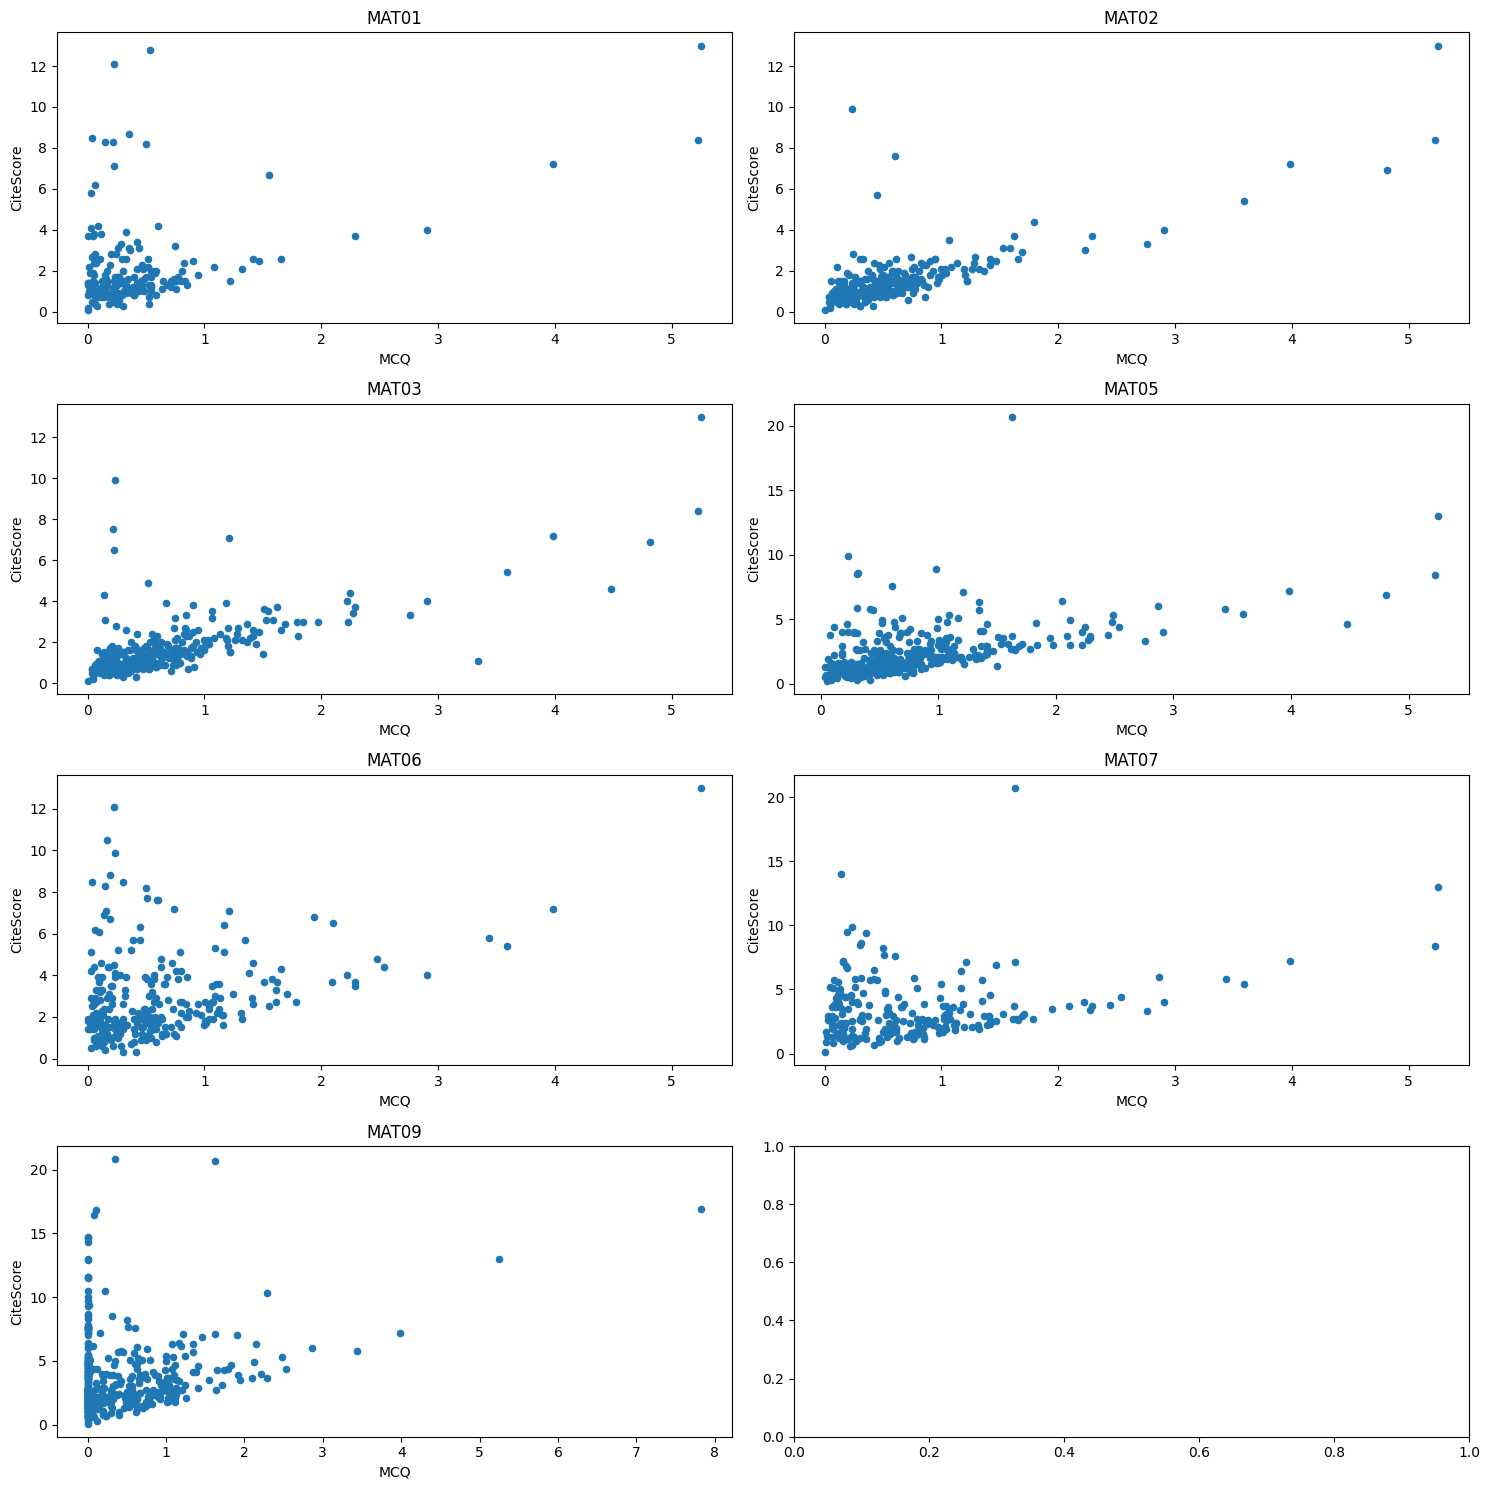

In [37]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
df.loc[df['SETTORE']=='MAT01'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[0,0],title="MAT01")
df.loc[df['SETTORE']=='MAT02'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[0,1],title="MAT02")
df.loc[df['SETTORE']=='MAT03'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[1,0],title="MAT03")
df.loc[df['SETTORE']=='MAT05'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[1,1],title="MAT05")
df.loc[df['SETTORE']=='MAT06'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[2,0],title="MAT06")
df.loc[df['SETTORE']=='MAT07'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[2,1],title="MAT07")
df.loc[df['SETTORE']=='MAT08'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[3,0],title="MAT08")
df.loc[df['SETTORE']=='MAT09'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[3,0],title="MAT09")
plt.tight_layout()

In [26]:
df.loc[df['SETTORE']=="MAT08"].sort_values(by=['CiteScore'],ascending=False).head(10)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1752,IEEE Transactions on Neural Networks and Learn...,2162237X,MAT08,3.555,20.8,0.344097,2.137477
1887,SIAM Review,00361445,MAT08,3.910,20.7,1.625899,2.027626
1667,Acta Numerica,09624929,MAT08,4.358,16.9,7.827586,3.463842
1771,International Journal of Computer Vision,09205691,MAT08,4.121,16.8,0.108696,2.382597
1750,IEEE Transactions on Image Processing,10577149,MAT08,2.893,16.4,0.083445,1.958517
1676,Annals of Mathematics,0003486X,MAT08,7.770,13.0,5.253589,3.288723
1753,IEEE Transactions on Signal Processing,1053587X,MAT08,2.098,10.5,0.225021,1.332421
1722,Computer Methods in Applied Mechanics and Engi...,00457825; 03742830,MAT08,2.786,10.3,2.292758,1.255568
1749,IEEE Transactions on Antennas and Propagation,0018926X,MAT08,1.697,9.4,0.020510,1.844553
1678,Applied Mathematical Modelling,0307904X,MAT08,0.957,8.5,0.306138,0.535616


# SJR vs CiteScore

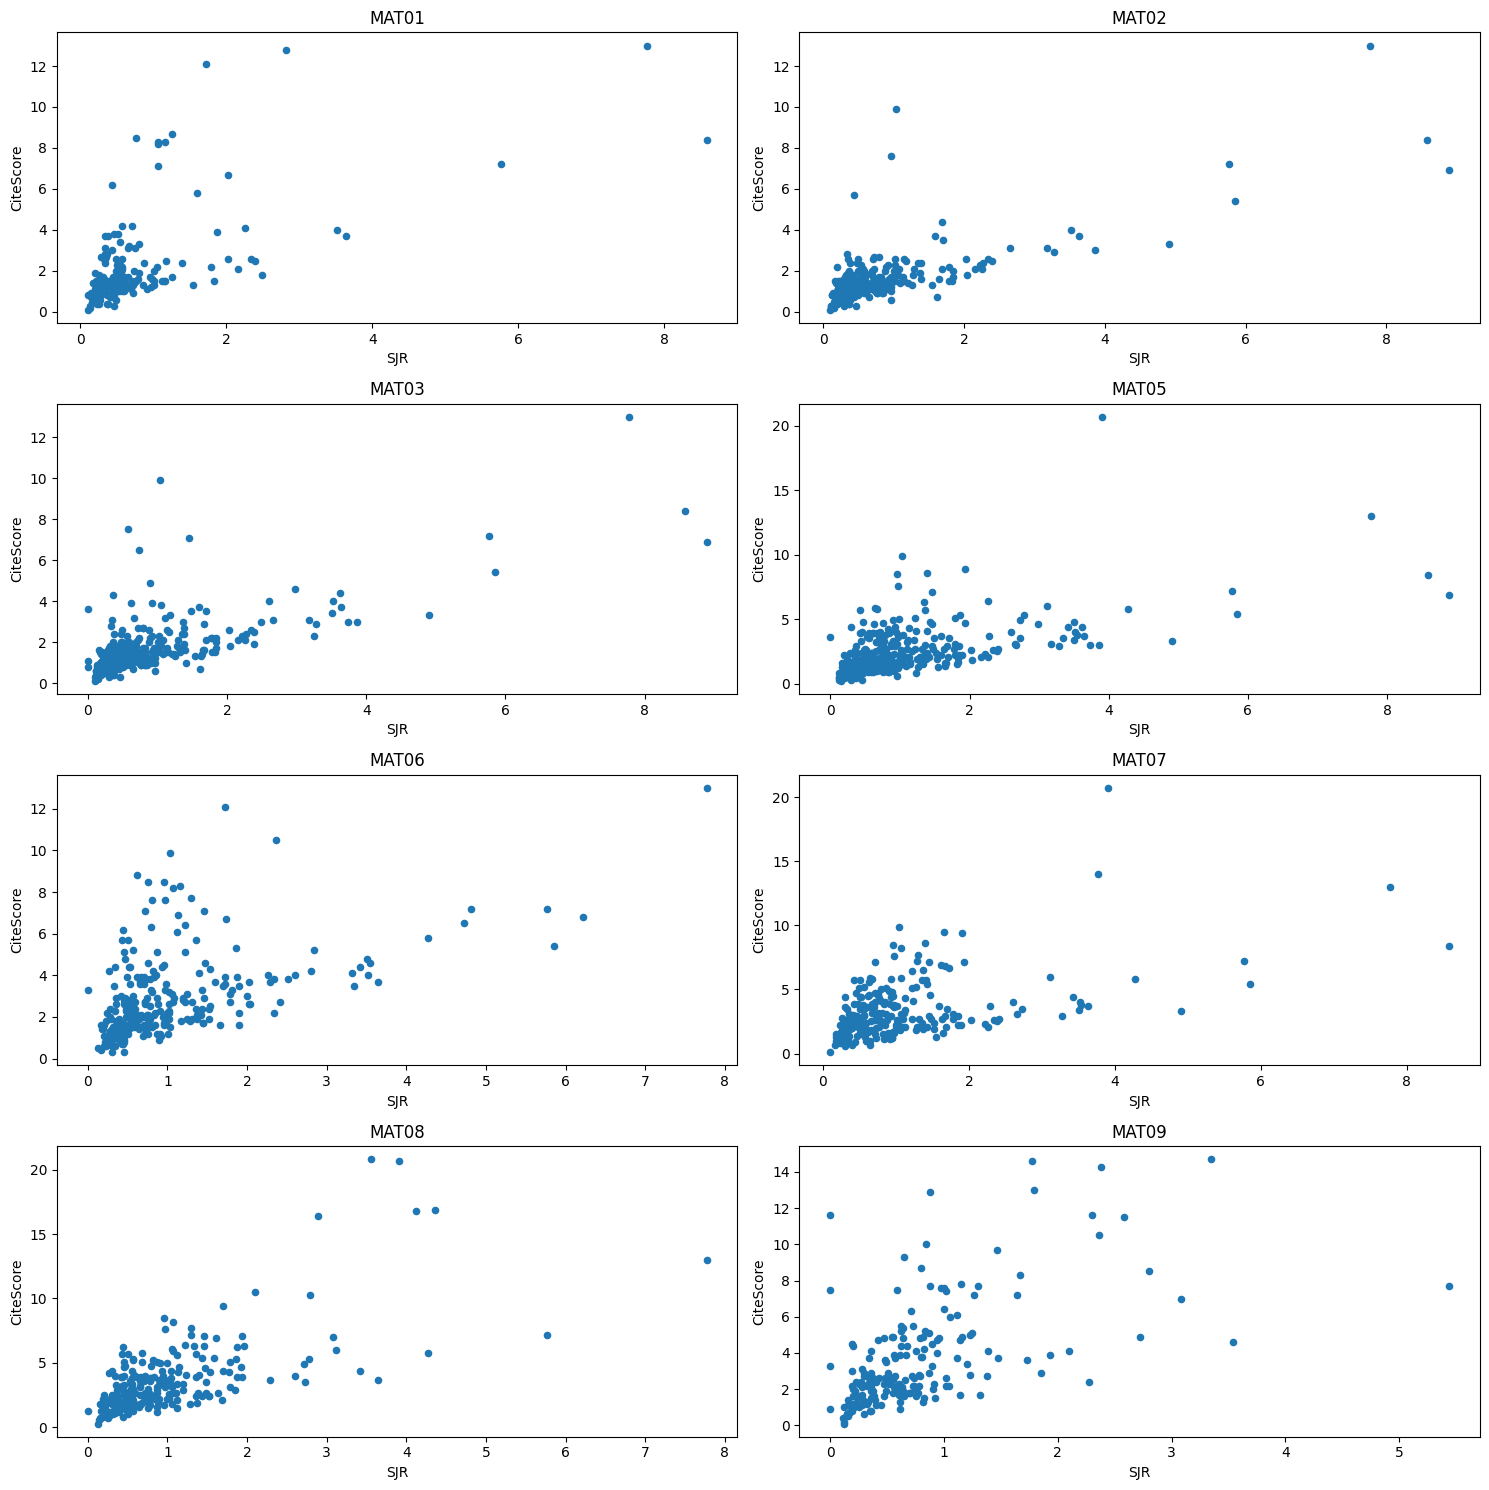

In [45]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
df.loc[df['SETTORE']=='MAT01'].plot.scatter(x="SJR",y="CiteScore",ax=axes[0,0],title="MAT01")
df.loc[df['SETTORE']=='MAT02'].plot.scatter(x="SJR",y="CiteScore",ax=axes[0,1],title="MAT02")
df.loc[df['SETTORE']=='MAT03'].plot.scatter(x="SJR",y="CiteScore",ax=axes[1,0],title="MAT03")
df.loc[df['SETTORE']=='MAT05'].plot.scatter(x="SJR",y="CiteScore",ax=axes[1,1],title="MAT05")
df.loc[df['SETTORE']=='MAT06'].plot.scatter(x="SJR",y="CiteScore",ax=axes[2,0],title="MAT06")
df.loc[df['SETTORE']=='MAT07'].plot.scatter(x="SJR",y="CiteScore",ax=axes[2,1],title="MAT07")
df.loc[df['SETTORE']=='MAT08'].plot.scatter(x="SJR",y="CiteScore",ax=axes[3,0],title="MAT08")
df.loc[df['SETTORE']=='MAT09'].plot.scatter(x="SJR",y="CiteScore",ax=axes[3,1],title="MAT09")
plt.tight_layout()

In [28]:
df.loc[df['SETTORE']=="MAT08"].sort_values(by=['CiteScore'],ascending=False).head(10)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1752,IEEE Transactions on Neural Networks and Learn...,2162237X,MAT08,3.555,20.8,0.344097,2.137477
1887,SIAM Review,00361445,MAT08,3.910,20.7,1.625899,2.027626
1667,Acta Numerica,09624929,MAT08,4.358,16.9,7.827586,3.463842
1771,International Journal of Computer Vision,09205691,MAT08,4.121,16.8,0.108696,2.382597
1750,IEEE Transactions on Image Processing,10577149,MAT08,2.893,16.4,0.083445,1.958517
1676,Annals of Mathematics,0003486X,MAT08,7.770,13.0,5.253589,3.288723
1753,IEEE Transactions on Signal Processing,1053587X,MAT08,2.098,10.5,0.225021,1.332421
1722,Computer Methods in Applied Mechanics and Engi...,00457825; 03742830,MAT08,2.786,10.3,2.292758,1.255568
1749,IEEE Transactions on Antennas and Propagation,0018926X,MAT08,1.697,9.4,0.020510,1.844553
1678,Applied Mathematical Modelling,0307904X,MAT08,0.957,8.5,0.306138,0.535616


## SJR VS SNIP

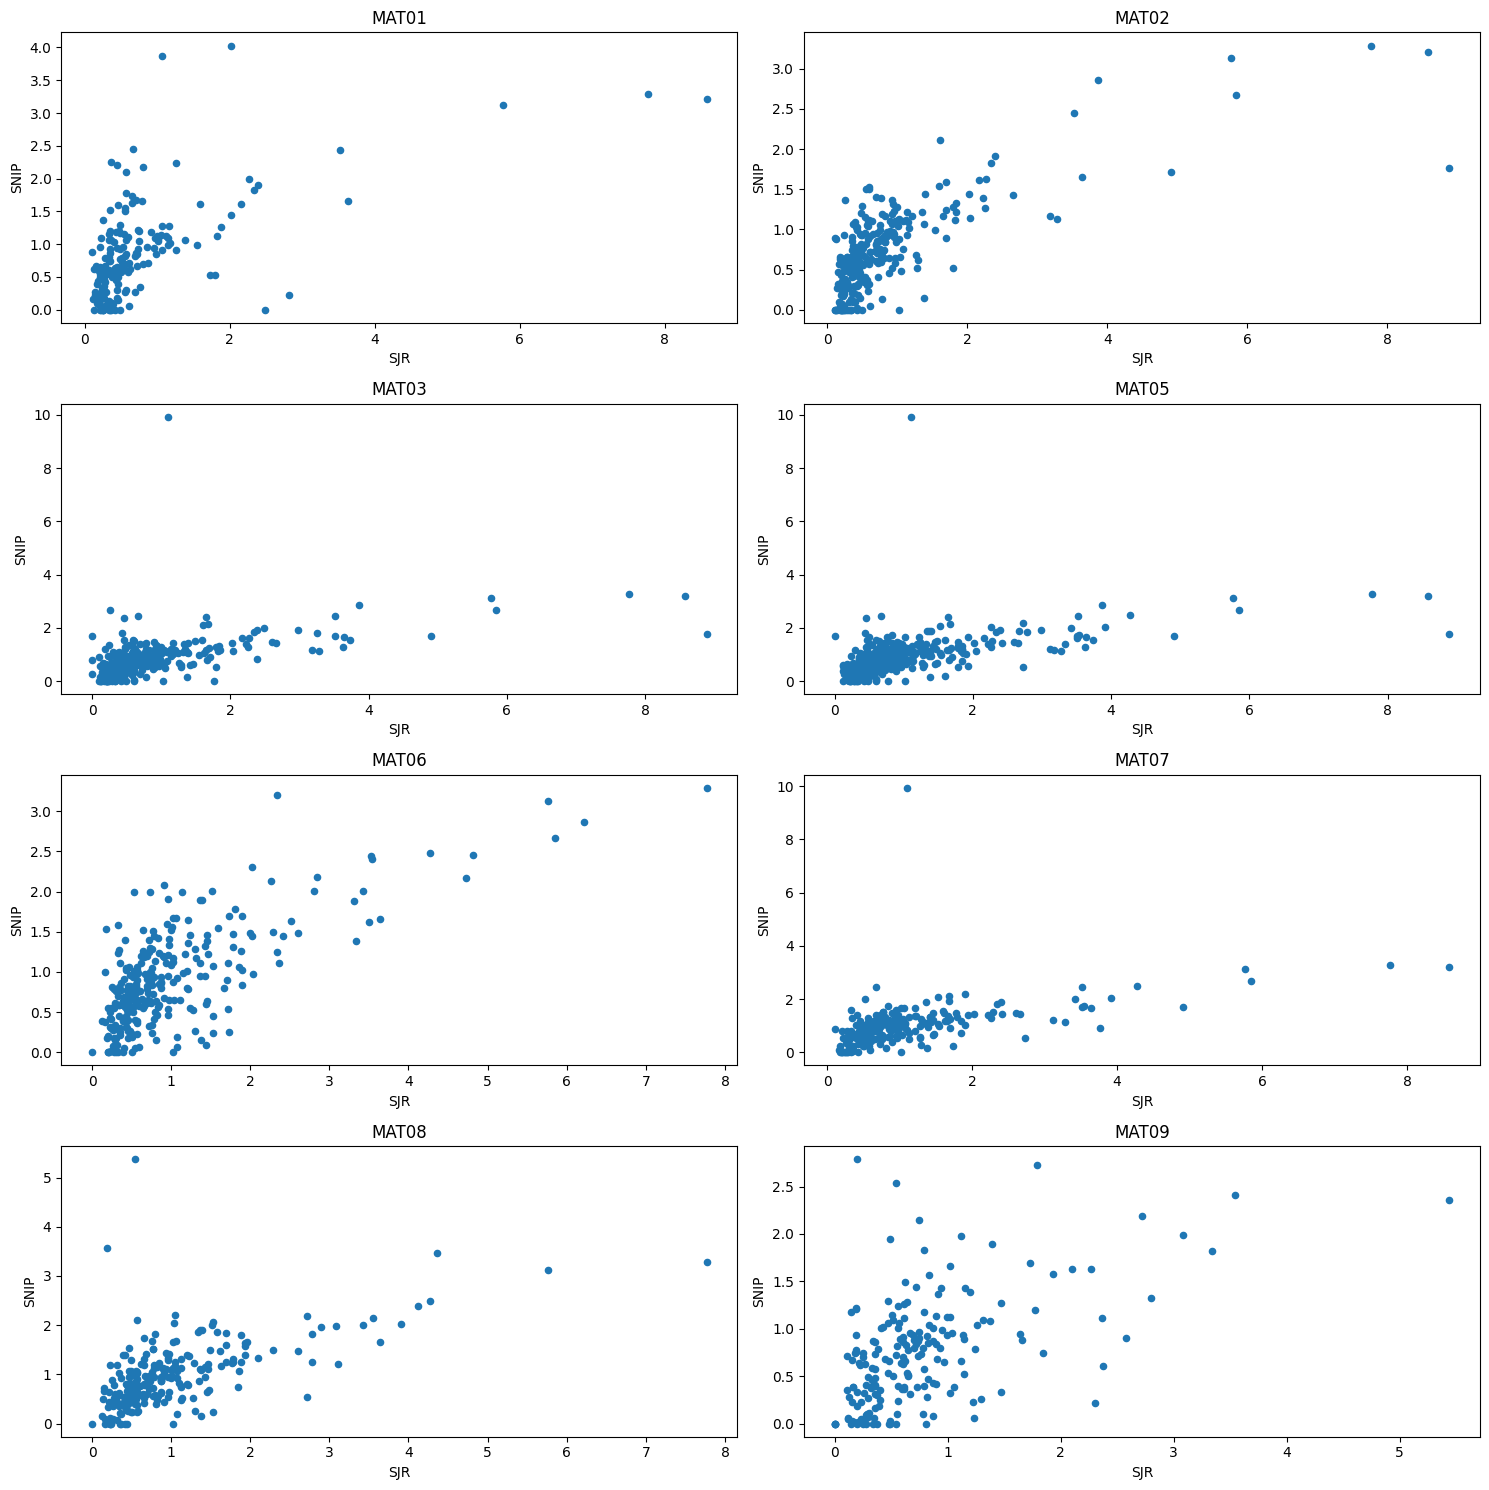

In [44]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
df.loc[df['SETTORE']=='MAT01'].plot.scatter(x="SJR",y="SNIP",ax=axes[0,0],title="MAT01")
df.loc[df['SETTORE']=='MAT02'].plot.scatter(x="SJR",y="SNIP",ax=axes[0,1],title="MAT02")
df.loc[df['SETTORE']=='MAT03'].plot.scatter(x="SJR",y="SNIP",ax=axes[1,0],title="MAT03")
df.loc[df['SETTORE']=='MAT05'].plot.scatter(x="SJR",y="SNIP",ax=axes[1,1],title="MAT05")
df.loc[df['SETTORE']=='MAT06'].plot.scatter(x="SJR",y="SNIP",ax=axes[2,0],title="MAT06")
df.loc[df['SETTORE']=='MAT07'].plot.scatter(x="SJR",y="SNIP",ax=axes[2,1],title="MAT07")
df.loc[df['SETTORE']=='MAT08'].plot.scatter(x="SJR",y="SNIP",ax=axes[3,0],title="MAT08")
df.loc[df['SETTORE']=='MAT09'].plot.scatter(x="SJR",y="SNIP",ax=axes[3,1],title="MAT09")
plt.tight_layout()

## Uno sguardo più approfondito alle misure

Controlliamo le distribuzioni globali delle varie misure.

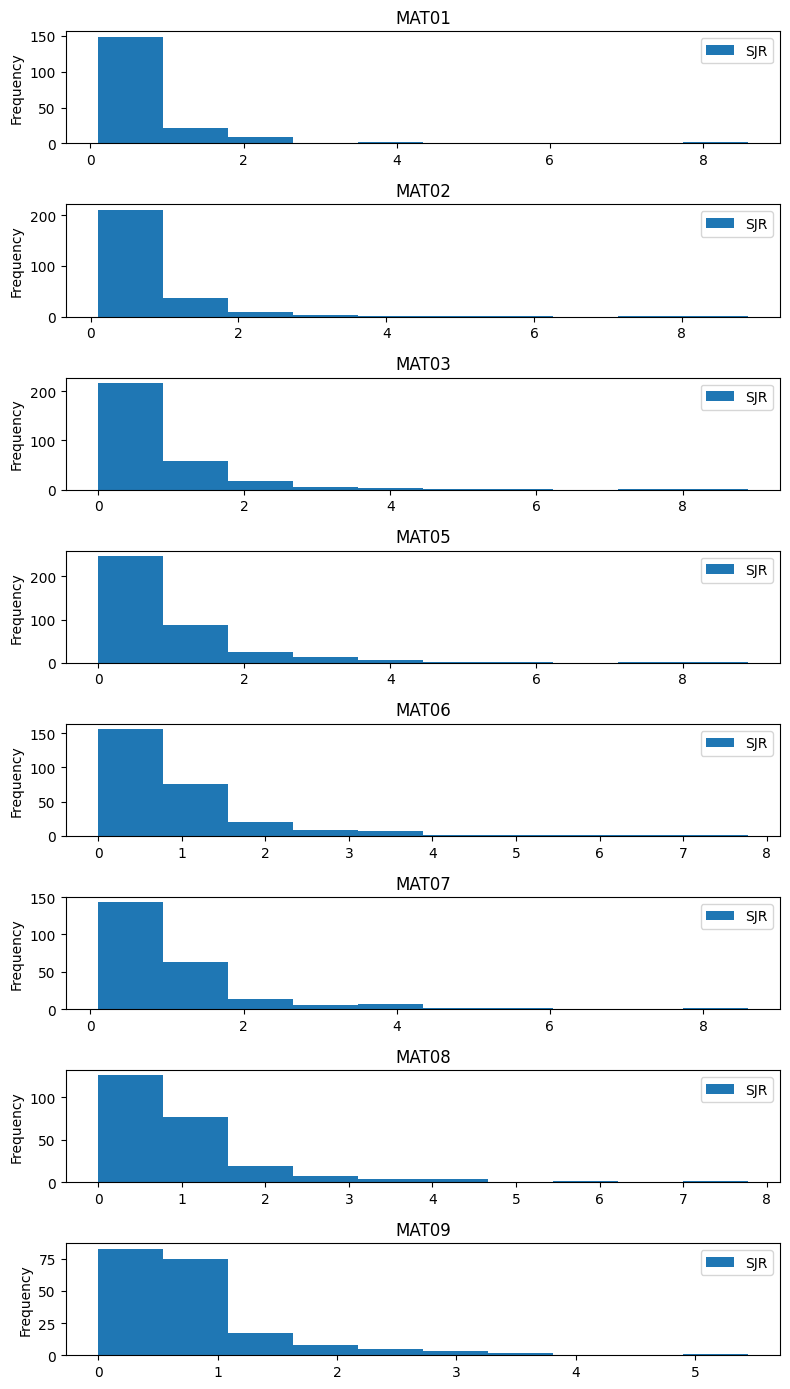

In [42]:
df.plot.hist(column=['SJR'],by="SETTORE",figsize=(8,14))
plt.tight_layout()

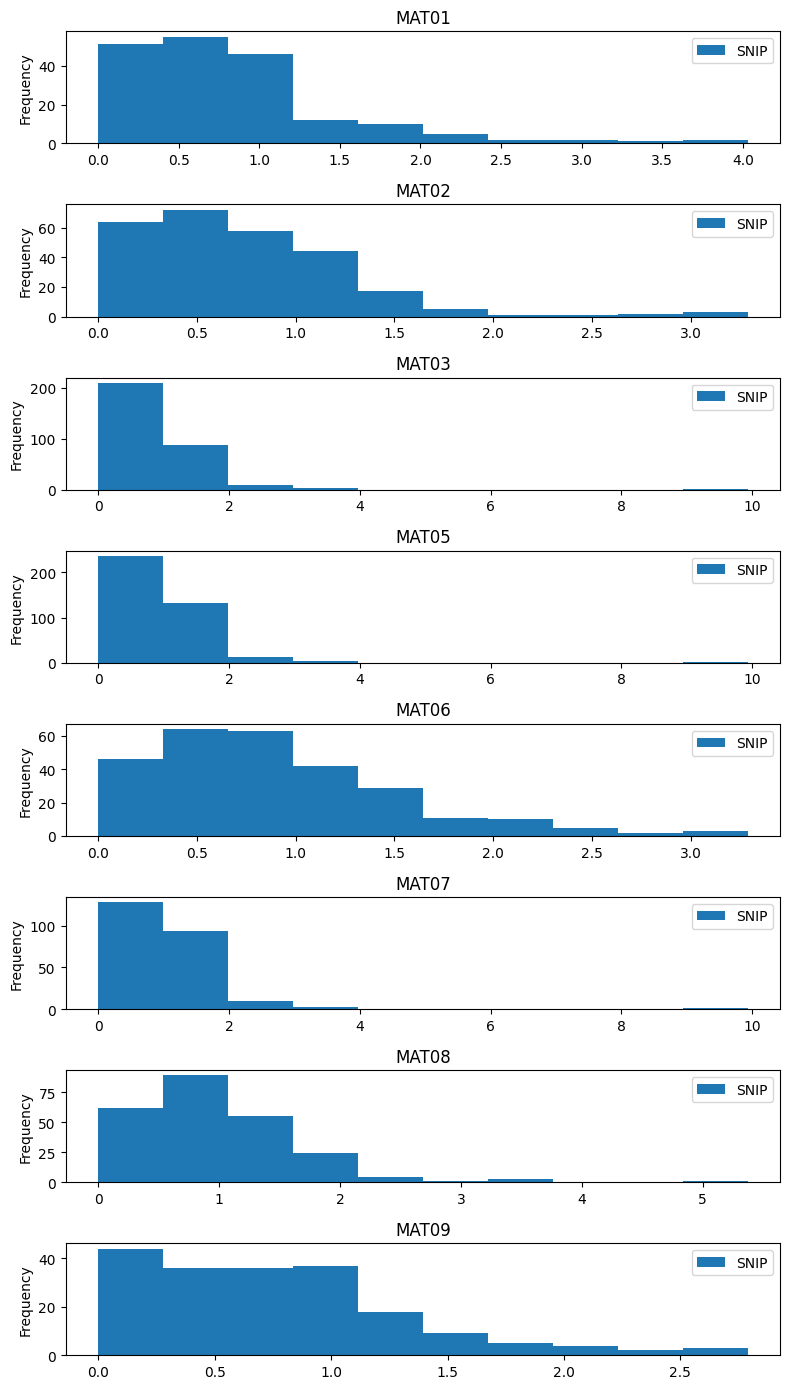

In [48]:
df.plot.hist(column=['SNIP'],by="SETTORE",figsize=(8,14))
plt.tight_layout()

In [49]:
df.loc[df['SETTORE']=="MAT08"].sort_values(by=['SNIP'],ascending=False).head(20)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1775,Internet Mathematics,15427951,MAT08,0.540,2.0,0.329114,5.371190
1819,"Journal of Numerical Analysis, Industrial and ...",17908140,MAT08,0.185,1.5,0.142857,3.573285
1667,Acta Numerica,09624929,MAT08,4.358,16.9,7.827586,3.463842
1676,Annals of Mathematics,0003486X,MAT08,7.770,13.0,5.253589,3.288723
1665,Acta Mathematica,00015962,MAT08,5.766,7.2,3.984615,3.128416
1703,Communications on Pure and Applied Mathematics,00103640,MAT08,4.271,5.8,3.434615,2.484668
1771,International Journal of Computer Vision,09205691,MAT08,4.121,16.8,0.108696,2.382597
1691,CAD Computer Aided Design,00104485,MAT08,1.052,6.1,0.633333,2.212066
1886,SIAM Journal on Optimization,10526234,MAT08,2.720,4.9,2.119181,2.184800
1752,IEEE Transactions on Neural Networks and Learn...,2162237X,MAT08,3.555,20.8,0.344097,2.137477


In [50]:
df.loc[df['SETTORE']=="MAT09"].sort_values(by=['SNIP'],ascending=False).head(20)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1923,Computational Social Networks,0,MAT09,0.203,4.4,0.0,2.788105
2036,Mathematical Programming Computation,18672949,MAT09,1.790,13.0,0.0,2.730562
2081,TOP,11345764,MAT09,0.542,2.5,0.0,2.537234
2056,Operations Research,0030364X,MAT09,3.539,4.6,0.0,2.411742
2031,Management Science,00251909,MAT09,5.439,7.7,0.0,2.360654
2075,SIAM Journal on Optimization,10526234,MAT09,2.720,4.9,0.0,2.184800
2023,Journal of Rail Transport Planning and Management,22109706,MAT09,0.751,4.1,0.0,2.142504
2035,Mathematical Programming,00255610,MAT09,3.082,7.0,0.0,1.987170
2024,Journal of Scheduling,10946136,MAT09,1.117,3.7,0.0,1.973735
2001,Journal of Experimental Algorithmics,10846654,MAT09,0.490,3.5,0.0,1.941942


In [51]:
df.loc[df['SETTORE']=="MAT07"].sort_values(by=['SNIP'],ascending=False).head(20)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1434,Advances in Theoretical and Mathematical Physics,10950761,MAT07,1.105,3.2,1.066667,9.930169
1447,Annals of Mathematics,0003486X,MAT07,7.770,13.0,5.253589,3.288723
1573,Journal of the American Mathematical Society,08940347,MAT07,8.581,8.4,5.224806,3.209943
1425,Acta Mathematica,00015962,MAT07,5.766,7.2,3.984615,3.128416
1530,Inventiones Mathematicae,00209910,MAT07,5.848,5.4,3.589532,2.668075
1478,Communications on Pure and Applied Mathematics,00103640,MAT07,4.271,5.8,3.434615,2.484668
1463,Bulletin of the American Mathematical Society,02730979,MAT07,0.669,3.2,0.747253,2.457252
1601,Memoirs of the American Mathematical Society,00659266,MAT07,3.520,4.0,2.909639,2.443752
1576,Journal of the Mechanics and Physics of Solids,00225096,MAT07,1.899,9.4,0.351690,2.185320
1470,Communications in Contemporary Mathematics,02191997,MAT07,1.675,2.9,1.360947,2.129011
